# Breed classification

This notebook lists all the steps that you need to complete this project. You will need to complete all the TODOs in this notebook as well as in the README and the two python scripts included with the starter code.


**TODO**: Give a helpful introduction to what this notebook is for. Remember that comments, explanations and good documentation make your project informative and professional.

**Note:** This notebook has a bunch of code and markdown cells with TODOs that you have to complete. These are meant to be helpful guidelines for you to finish your project while meeting the requirements in the project rubrics. Feel free to change the order of these the TODO's and use more than one TODO code cell to do all your tasks.

In [2]:
%%capture
# For instance, you will need the smdebug package
import sys
!{sys.executable} -m pip install smdebug torch torchvision tqdm

In [3]:
# Standard library imports
import os
import csv
import io
from pprint import pprint

# Third-party imports
import numpy as np
import pandas as pd
from PIL import Image
import boto3
from botocore.exceptions import NoCredentialsError

# SageMaker imports
import sagemaker
from sagemaker.pytorch import PyTorch, PyTorchModel
from sagemaker.tuner import HyperparameterTuner, CategoricalParameter, ContinuousParameter, IntegerParameter
from sagemaker.inputs import TrainingInput
from sagemaker.debugger import (
    DebuggerHookConfig,
    Rule,
    ProfilerRule,
    rule_configs,
    TensorBoardOutputConfig,
    ProfilerConfig,
    FrameworkProfile
)

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys

from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob

from sagemaker.predictor import Predictor

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /root/.config/sagemaker/config.yaml
[2024-08-06 00:00:16.459 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:6801 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None


## Dataset

For this project, we are using the Udacity Dog Breed Identification dataset. This dataset contains images of dogs categorized into different breeds and is used for training machine learning models to identify dog breeds from images.

In [4]:
#%%capture
#!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
#!unzip dogImages.zip

In [17]:
# Initialize S3 client
s3 = boto3.client('s3')

In [18]:
# Define the default bucket
default_bucket = sagemaker.Session().default_bucket()
print(default_bucket)

sagemaker-us-east-1-482545180177


In [19]:
role = sagemaker.get_execution_role()

In [8]:
#%%capture
#!aws s3 cp dogImages s3://{default_bucket}/ --recursive

In [9]:
#%%capture
#!aws s3 cp dogImages s3://{default_bucket}/ --recursive

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [10]:
hyperparameter_ranges = {
    "learning_rate": ContinuousParameter(0.001, 0.1),
    "batch_size": CategoricalParameter([32, 64, 128, 256, 512]),
}

objective_metric_name = "Test Loss"
objective_type = "Minimize"
metric_definitions = [{"Name": "Test Loss", "Regex": "Testing Loss: ([0-9\\.]+)"}]

In [11]:
estimator = PyTorch(
    entry_point="train_model.py",
    base_job_name='pytorch_dog_hpo',
    role=role,
    framework_version="1.4.0",
    instance_count=1,
    instance_type="ml.g4dn.xlarge",
    py_version='py3'
)

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=2,
    max_parallel_jobs=1,
    objective_type=objective_type
)

In [8]:
os.environ['SM_CHANNEL_TRAINING']=f's3://{default_bucket}/'
os.environ['SM_MODEL_DIR']=f's3://{default_bucket}/model/'
os.environ['SM_OUTPUT_DATA_DIR']=f's3://{default_bucket}/output/'

In [ ]:
tuner.fit({"training": f's3://{default_bucket}/'})

In [19]:
# Get the best estimators and the best HPs
best_estimator = tuner.best_estimator()

In [20]:
# Get the hyperparameters of the best trained model
best_hyperparameters = best_estimator.hyperparameters()

# Print the best hyperparameters
print("Best hyperparameters:")
pprint(best_hyperparameters)

## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [21]:
#hyperparameters = {"batch_size": int(best_estimator.hyperparameters()['batch_size'].replace('"', '')), \
#                   "learning_rate": best_estimator.hyperparameters()['learning_rate']}
#hyperparameters

In [9]:
hyperparameters = {'batch_size': 128, 'learning_rate': '0.002113708441112964'}

In [11]:
rules = [
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
]

In [12]:
hook_config = DebuggerHookConfig(
    hook_parameters={
        "train.save_interval": "1",
        "eval.save_interval": "1"
    }
)

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=1)
)

Framework profiling will be deprecated from tensorflow 2.12 and pytorch 2.0 in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


In [13]:
#adjust this cell to accomplish multi-instance training
estimator = PyTorch(
    entry_point='hpo.py',
    base_job_name='dog-pytorch',
    role=role,
    instance_count=1,
    instance_type='ml.m5.xlarge',
    framework_version='1.4.0',
    py_version='py3',
    hyperparameters=hyperparameters,
    ## Debugger and Profiler parameters
    rules = rules,
    debugger_hook_config=hook_config,
    profiler_config=profiler_config,
)

In [ ]:
# Define the input data channels
inputs = {'training': f's3://{default_bucket}/'}

# Fit the estimator
estimator.fit(inputs)

In [ ]:
job_name = "dog-pytorch-2024-08-05-23-57-41-000"

In [26]:
debugger_artifacts_path = f"s3://{default_bucket}/{job_name}/debug-output/"

In [27]:
# Create a trial using the debugger artifacts path
#trial = create_trial(estimator.latest_job_debugger_artifacts_path())
trial = create_trial(debugger_artifacts_path)

[2024-08-06 01:50:11.878 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:6801 INFO s3_trial.py:42] Loading trial  at path s3://sagemaker-us-east-1-482545180177/dog-pytorch-2024-08-05-23-57-41-000/debug-output/


In [28]:
trial.tensor_names()

[2024-08-06 01:50:21.284 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:6801 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-08-06 01:50:22.309 sagemaker-data-scienc-ml-t3-medium-ccb588b5efaf671be41927273f0c:6801 INFO trial.py:210] Loaded all steps


['CrossEntropyLoss_output_0',
 'gradient/ResNet_fc.0.bias',
 'gradient/ResNet_fc.0.weight',
 'gradient/ResNet_fc.2.bias',
 'gradient/ResNet_fc.2.weight',
 'layer1.0.relu_input_0',
 'layer1.0.relu_input_1',
 'layer1.0.relu_input_2',
 'layer1.1.relu_input_0',
 'layer1.1.relu_input_1',
 'layer1.1.relu_input_2',
 'layer1.2.relu_input_0',
 'layer1.2.relu_input_1',
 'layer1.2.relu_input_2',
 'layer2.0.relu_input_0',
 'layer2.0.relu_input_1',
 'layer2.0.relu_input_2',
 'layer2.1.relu_input_0',
 'layer2.1.relu_input_1',
 'layer2.1.relu_input_2',
 'layer2.2.relu_input_0',
 'layer2.2.relu_input_1',
 'layer2.2.relu_input_2',
 'layer2.3.relu_input_0',
 'layer2.3.relu_input_1',
 'layer2.3.relu_input_2',
 'layer3.0.relu_input_0',
 'layer3.0.relu_input_1',
 'layer3.0.relu_input_2',
 'layer3.1.relu_input_0',
 'layer3.1.relu_input_1',
 'layer3.1.relu_input_2',
 'layer3.2.relu_input_0',
 'layer3.2.relu_input_1',
 'layer3.2.relu_input_2',
 'layer3.3.relu_input_0',
 'layer3.3.relu_input_1',
 'layer3.3.rel

In [29]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode = ModeKeys.TRAIN))

53

In [30]:
len(trial.tensor("CrossEntropyLoss_output_0").steps(mode = ModeKeys.EVAL))

14

In [31]:
def get_data(trial, tname, mode):
    tensor = trial.tensor(tname)
    steps = tensor.steps(mode = mode)
    vals = []
    for s in steps:
        vals.append(tensor.value(s, mode = mode))
    return steps, vals

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot


def plot_tensor(trial, tensor_name):

    steps_train, vals_train = get_data(trial, tensor_name, mode = ModeKeys.TRAIN)
    print("loaded TRAIN data")
    steps_eval, vals_eval = get_data(trial, tensor_name, mode = ModeKeys.EVAL)
    print("loaded EVAL data")

    fig = plt.figure(figsize = (10, 7))
    host = host_subplot(111)

    par = host.twiny()

    host.set_xlabel("Steps (TRAIN)")
    par.set_xlabel("Steps (EVAL)")
    host.set_ylabel(tensor_name)

    (p1, ) = host.plot(steps_train, vals_train, label = tensor_name)
    print("completed TRAIN plot")
    (p2, ) = par.plot(steps_eval, vals_eval, label = "val_" + tensor_name)
    print("completed EVAL plot")
    leg = plt.legend()

    host.xaxis.get_label().set_color(p1.get_color())
    leg.texts[0].set_color(p1.get_color())

    par.xaxis.get_label().set_color(p2.get_color())
    leg.texts[1].set_color(p2.get_color())

    plt.ylabel(tensor_name)

    plt.show()
    plt.savefig('debug-out.png')

loaded TRAIN data
loaded EVAL data
completed TRAIN plot
completed EVAL plot


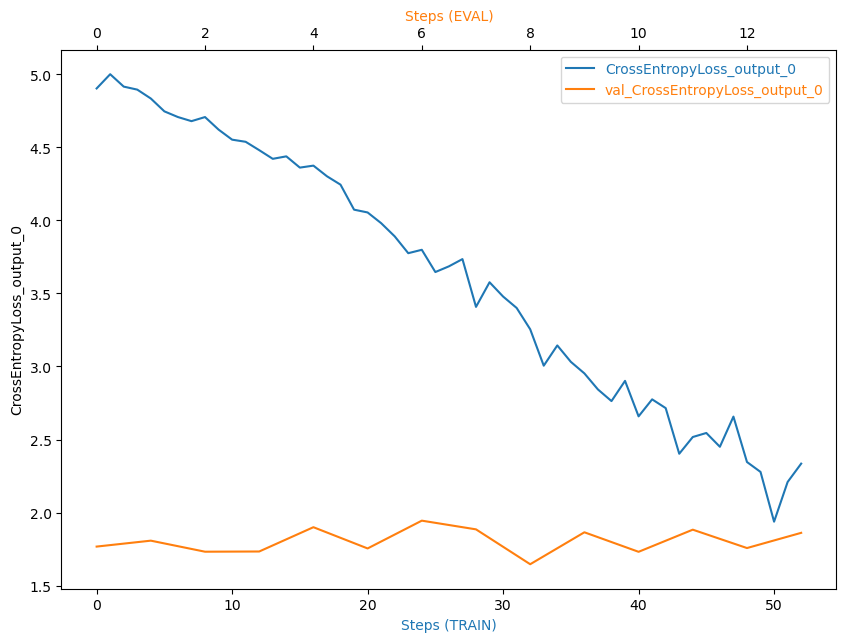

<Figure size 640x480 with 0 Axes>

In [33]:
# TODO: Plot a debugging output.

plot_tensor(trial, "CrossEntropyLoss_output_0")

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**TODO**: If not, suppose there was an error. What would that error look like and how would you have fixed it?

In [35]:
# TODO: Display the profiler output

#rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
rule_output_path = f"s3://{default_bucket}/{job_name}/rule-output/"

In [36]:
! aws s3 ls {rule_output_path} --recursive

2024-08-06 00:24:10     329705 dog-pytorch-2024-08-05-23-57-41-000/rule-output/ProfilerReport/profiler-output/profiler-report.html
2024-08-06 00:24:09     171066 dog-pytorch-2024-08-05-23-57-41-000/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2024-08-06 00:24:05        192 dog-pytorch-2024-08-05-23-57-41-000/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2024-08-06 00:24:05        200 dog-pytorch-2024-08-05-23-57-41-000/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2024-08-06 00:24:05        126 dog-pytorch-2024-08-05-23-57-41-000/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2024-08-06 00:24:05        127 dog-pytorch-2024-08-05-23-57-41-000/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
2024-08-06 00:24:05        199 dog-pytorch-2024-08-05-23-57-41-000/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
2024-08-06 

In [37]:
! aws s3 cp {rule_output_path} ./ --recursive

download: s3://sagemaker-us-east-1-482545180177/dog-pytorch-2024-08-05-23-57-41-000/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json to ProfilerReport/profiler-output/profiler-reports/Dataloader.json
download: s3://sagemaker-us-east-1-482545180177/dog-pytorch-2024-08-05-23-57-41-000/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json to ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
download: s3://sagemaker-us-east-1-482545180177/dog-pytorch-2024-08-05-23-57-41-000/rule-output/ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json to ProfilerReport/profiler-output/profiler-reports/OverallFrameworkMetrics.json
download: s3://sagemaker-us-east-1-482545180177/dog-pytorch-2024-08-05-23-57-41-000/rule-output/ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json to ProfilerReport/profiler-output/profiler-reports/IOBottleneck.json
download: s3://sagemaker-us-east-1-482545180177/

In [39]:
#import os

# get the autogenerated folder name of profiler report
#profiler_report_name = [
#    rule["RuleConfigurationName"]
#    for rule in estimator.latest_training_job.rule_job_summary()
#    if "Profiler" in rule["RuleConfigurationName"]
#][0]

In [ ]:
#import IPython

#IPython.display.HTML(filename = profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [41]:
#model_location = estimator.model_data
#print(f"Model artifact path: {model_artifact}")

In [42]:
model_location = f"s3://{default_bucket}/{job_name}/output/model.tar.gz"

In [43]:
jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session = sagemaker_session,
            serializer = jpeg_serializer,
            deserializer = json_deserializer
        )

In [47]:
pytorch_model = PyTorchModel(model_data=model_location, 
                             role=role, 
                             entry_point='inference.py',
                             py_version='py3',
                             framework_version='1.4',
                             predictor_cls=ImagePredictor)

In [48]:
predictor = pytorch_model.deploy(initial_instance_count=1, instance_type='ml.m5.large')

INFO:sagemaker:Repacking model artifact (s3://sagemaker-us-east-1-482545180177/dog-pytorch-2024-08-05-23-57-41-000/output/model.tar.gz), script artifact (None), and dependencies ([]) into single tar.gz file located at s3://sagemaker-us-east-1-482545180177/pytorch-inference-2024-08-06-02-01-14-130/model.tar.gz. This may take some time depending on model size...
INFO:sagemaker:Creating model with name: pytorch-inference-2024-08-06-02-01-24-364
INFO:sagemaker:Creating endpoint-config with name pytorch-inference-2024-08-06-02-01-25-401
INFO:sagemaker:Creating endpoint with name pytorch-inference-2024-08-06-02-01-25-401


------!

The dog photo used to do the prediction is:


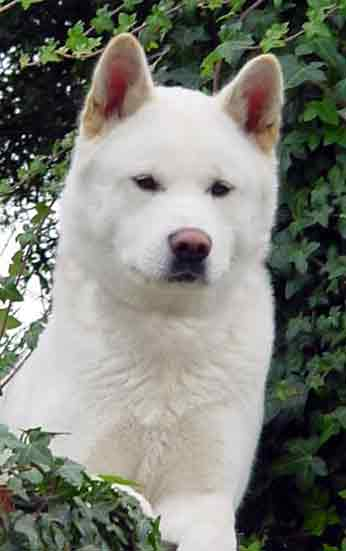

In [49]:
# Run an prediction on the endpoint
dog = './dogImages/test/004.Akita/Akita_00258.jpg'
label = 4

# Displaying image to be predicted
img = Image.open(dog)
print('The dog photo used to do the prediction is:')
display(img)

In [50]:
with open(dog, "rb") as image:
    f = image.read()
    img_bytes = bytearray(f)

type(img_bytes)

bytearray

In [51]:
# Querying endpoint
response = predictor.predict(img_bytes, initial_args = {'ContentType':'image/jpeg'})

In [52]:

prediction = np.argmax(response[0]) + 1    

print(f'The label of the image is {label}')
print(f'The prediction given by the machine learning model is {prediction}\n')

The label of the image is 4
The prediction given by the machine learning model is 4



In [ ]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
#predictor.delete_endpoint()